In [ ]:
!apt-get install git

!git clone https://github.com/RemiVaucher/TopSig

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.12).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Cloning into 'TopSig'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
!pip install signatory
!pip install networkx
!pip install gudhi
!pip install sortedl1
!pip install mne
!pip install POT
!pip install hypergraphx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for signatory: filename=signatory-1.2.6.1.9.0-cp311-cp311-linux_x86_64.whl size=12019248 sha256=268c5894404b512d1ca9db6ae602bafbf0e6673ab437995e45a1bab6898b59bb
  Stored in directory: /root/.cache/pip/wheels/6a/79/bb/6012413145dd168da55413ef8bc837f507bf829a08a176c329
Successfully built signatory
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sortedl1: filename=sortedl1-0.4.0-cp311-cp311-linux_x86_64.whl size=259163 sha256=2d0bde1208709957a8caf863f4adfc14aa6ff4d90080fb7a1cf3e4ac08cee656
  Stored in directory: /root/.cache/pip/wheels/83/fd/33/ddb866260d

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [ ]:
%load_ext autoreload
%autoreload 2

import json
import torch
import matplotlib.pyplot as plt
from os import listdir
#import drawing
import numpy as np
import librosa
from tqdm import tqdm
import time
import re
import random
import networkx as nx
import gudhi
from gudhi.representations import BettiCurve
import itertools
from scipy.linalg import block_diag

import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)
import sys

%cd /content/drive/MyDrive/SigTDA_tests

from algo4 import SigComplex





The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/content/drive/MyDrive/SigTDA_tests


In [ ]:
def nx_simp(simplices):
#List of 0-simplices
    nodes = list(set(itertools.chain(*simplices)))

    #List of 1-simplices
    edges = list(set(itertools.chain(*[[tuple(sorted((i, j))) for i, j in itertools.combinations(simplex, 2)] for simplex in simplices])))

    #List of 2-simplices
    triangles = list(set(itertools.chain(*[[tuple(sorted((i, j, k))) for i, j, k in itertools.combinations(simplex, 3)] for simplex in simplices])))


        # Creating a networkx Graph from the edgelist
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
        # Creating a dictionary for the position of the nodes

    return G


def logistic(r, x):
    return (1 - r * (x**2))
    # alternative  chaotic map
    # return(4*x*(1-x))


# Reshuffle with probability p the links of the graph G yet ensuring that the graph
# remains connected (i.e. the degree distribution remains the same)
def double_switch_connected(G, p):
    N = len(G.nodes())
    nswap = int(p * N)
    counter_swaps = 0
    while counter_swaps < nswap:
        edges_to_switch = random.sample(list(G.edges()), 2)
        nodes_distinct = set(np.ravel(edges_to_switch))
        total_edges = G.edges()
        flag = 0
        if len(nodes_distinct) == 4:
            new_edge1 = (edges_to_switch[0][0], edges_to_switch[1][0])
            new_edge2 = (edges_to_switch[0][1], edges_to_switch[1][1])
            if new_edge1 not in total_edges and new_edge2 not in total_edges:
                G.add_edges_from([new_edge1, new_edge2])
                G.remove_edges_from(edges_to_switch)
                # Undo the swapping if the graph is not connected anymore
                if len(list(nx.connected_components(G))[0]) != N:
                    G.add_edges_from(edges_to_switch)
                    G.remove_edges_from([new_edge1, new_edge2])
                    flag = 1
                else:
                    counter_swaps += 1
                    flag = 2

            new_edge1 = (edges_to_switch[0][0], edges_to_switch[1][1])
            new_edge2 = (edges_to_switch[0][1], edges_to_switch[1][0])
            if flag <= 1:
                if new_edge1 not in total_edges and new_edge2 not in total_edges:
                    G.add_edges_from([new_edge1, new_edge2])
                    G.remove_edges_from(edges_to_switch)
                    # Undo the swapping if the graph is not connected anymore
                    if len(list(nx.connected_components(G))[0]) != N:
                        G.add_edges_from(edges_to_switch)
                        G.remove_edges_from([new_edge1, new_edge2])
                    else:
                        counter_swaps += 1
    return(G)


def generate_graph(N, m, p):
    G = nx.watts_strogatz_graph(n=N, k=m, p=p)
    #G = nx.dodecahedral_graph()
    # G=double_switch_connected(G,p=p)
    return(G)


N = 5
m = 2
p = 0.2

G = generate_graph(N,m,p)
lay = nx.circular_layout(G)

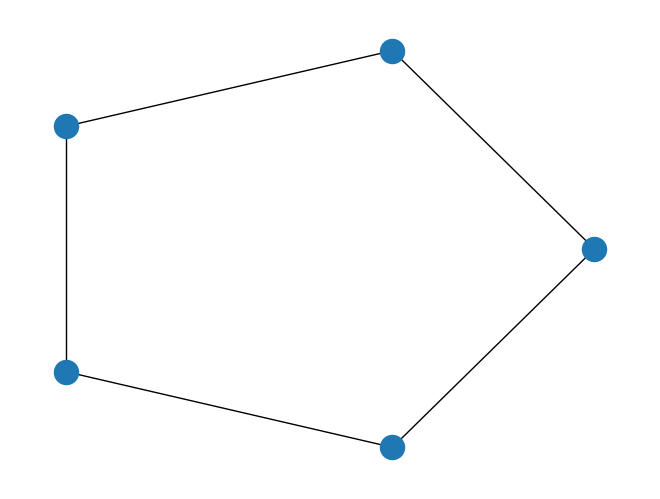

In [ ]:
nx.draw(G,pos = lay)
adj_mat = nx.adjacency_matrix(G).todense()

[[1. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0.]
 [0. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]]


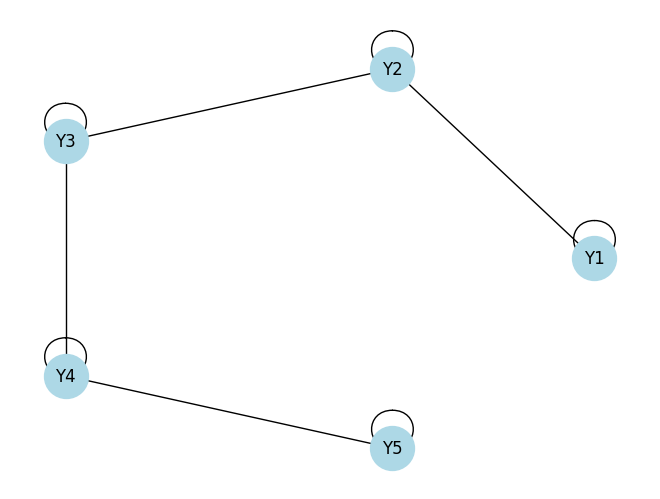

In [ ]:
mapping1 = {0 : "Y1", 1 : "Y2", 2 : "Y3", 3 : "Y4", 4 : "Y5"}
G = nx.from_numpy_array(np.eye(5)+np.eye(5,k=1)+np.eye(5,k=-1))
G = nx.relabel_nodes(G,mapping1)
lay = nx.circular_layout(G)
nx.draw(G,pos = lay,with_labels=True,node_size = 1000,node_color = "lightblue")

print(nx.adjacency_matrix(G).todense())

[[ 1.   0.1  0.1  0.   0.   0.   0.   0.   0.   0. ]
 [-0.1  1.   0.   0.1  0.   0.   0.   0.   0.   0. ]
 [-0.1  0.   1.   0.1  0.1  0.   0.   0.   0.   0. ]
 [ 0.  -0.1 -0.1  1.   0.   0.1  0.   0.   0.   0. ]
 [ 0.   0.  -0.1  0.   1.   0.1  0.1  0.   0.   0. ]
 [ 0.   0.   0.  -0.1 -0.1  1.   0.   0.1  0.   0. ]
 [ 0.   0.   0.   0.  -0.1  0.   1.   0.1  0.1  0. ]
 [ 0.   0.   0.   0.   0.  -0.1 -0.1  1.   0.   0.1]
 [ 0.   0.   0.   0.   0.   0.  -0.1  0.   1.   0.1]
 [ 0.   0.   0.   0.   0.   0.   0.  -0.1 -0.1  1. ]]


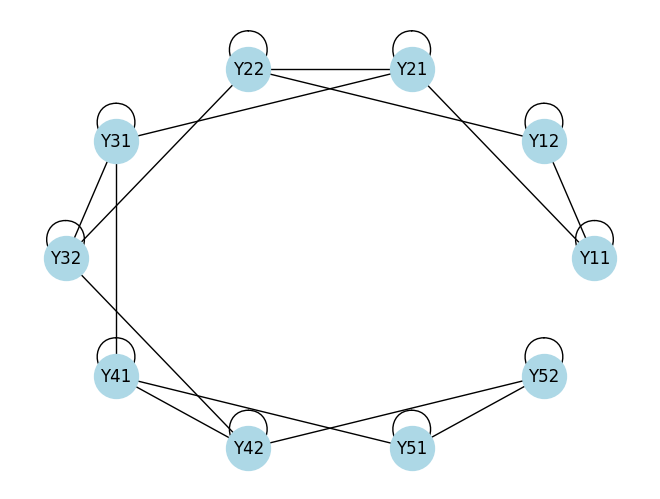

In [ ]:
scale = 10

mapping2 = {0 : "Y11", 1 : "Y12", 2 : "Y21", 3 : "Y22", 4 : "Y31", 5 : "Y32", 6 : "Y41", 7 : "Y42", 8 : "Y51", 9 : "Y52"}

A = np.eye(2)+np.eye(2,k=1)/scale-np.eye(2,k=-1)/scale

adj_true = block_diag(A,A,A,A,A)+np.eye(N*2,k=2)/scale-np.eye(N*2,k=-2)/scale
#adj_true /= 4
G = nx.from_numpy_array(adj_true)
G = nx.relabel_nodes(G,mapping2)
lay = nx.circular_layout(G)
nx.draw(G,pos = lay,with_labels = True,node_size = 1000,node_color = "lightblue")


print(adj_true)

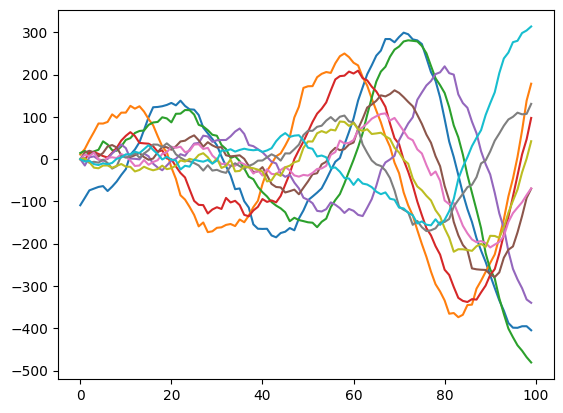

In [ ]:
def generate_dynamic(adj,T,noise_dyn,noise_ext):
  T0 = np.random.normal(scale = noise_dyn,size = adj.shape[0])
  T0[3:] = np.zeros(adj.shape[0]-3)
  series = np.zeros((adj.shape[0],T))
  series[:,0] = T0
  for t in range(1,T):
    series[:,t] = adj @ series[:,t-1] + np.random.normal(scale = noise_ext,size = adj.shape[0])
  return series

scale = 100
scale1 = 8

A = np.eye(2)+np.eye(2,k=1)/scale1-np.eye(2,k=-1)/scale1

adj_true = block_diag(A,A,A,A,A)+np.eye(N*2,k=2)/scale+np.eye(N*2,k=-2)/scale

T = 100

test = generate_dynamic(adj_true,T,100,10)
plt.plot(test.T)


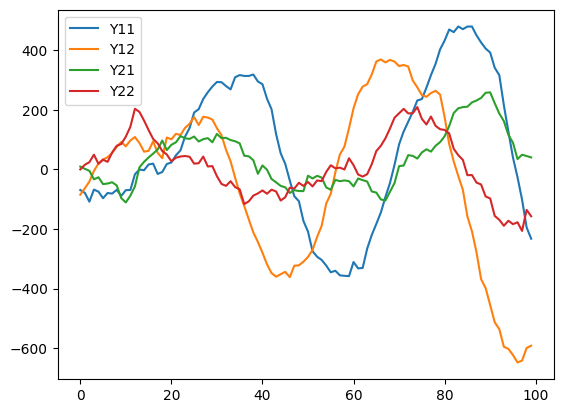

In [ ]:
plt.plot(test.T[:,0:4])
plt.legend(["Y11","Y12","Y21","Y22"])

In [ ]:
test.shape

(10, 100)

In [ ]:
MultiTS = torch.tensor(test.reshape([5,2,T])).swapaxes(-1,-2)
MultiTS -= MultiTS.mean(axis = 1)[:,None]
MultiTS /= MultiTS.max(axis = 1)[0][:,None]

In [ ]:
MultiTS.shape

torch.Size([5, 100, 2])

In [ ]:
np.sort(random.sample(range(MultiTS.shape[-2]),k=5))

array([37, 52, 58, 78, 89])

In [ ]:
%reload_ext autoreload
%autoreload 2
from algo5 import SigComplex

params = {"win" : 80,
          "alpha_1d" : 1e-2,
          "alpha_2d" : 1e100,
          "depth" : 6
    }

adj_all = []
adj_all1 = []

test = generate_dynamic(adj_true,T,100,20)

MultiTS = torch.tensor(test.reshape([5,2,T])).swapaxes(-1,-2)
MultiTS -= MultiTS.mean(axis = 1)[:,None]
MultiTS /= MultiTS.max(axis = 1)[0][:,None]

for i in tqdm(range(200)):

  idx = np.sort(random.sample(range(MultiTS.shape[-2]),k=params["win"]))

  com = SigComplex(MultiTS[:,idx], win = params["win"], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=True, max_iter = 1000)

  _complex ,_ , adj_mat_1d= com.complex_creation(0,verbose=False)

  adj_all.append(adj_mat_1d)
  adj_all1.append(adj_mat_1d>0.1)

adj_mats_mean = np.mean(np.array(adj_all),axis = 0)

adj_mats_sum = np.sum(np.array(adj_all),axis = 0)

adj_mats_mean1 = np.mean(np.array(adj_all1),axis = 0)

adj_mats_sum1 = np.sum(np.array(adj_all1),axis = 0)




100%|██████████| 200/200 [00:10<00:00, 19.02it/s]


[[False  True  True False False]
 [ True False  True False False]
 [ True  True False False False]
 [False False False False  True]
 [False  True False  True False]]
[[0.    1.    1.    0.    0.   ]
 [1.    0.    0.91  0.    0.38 ]
 [1.    0.905 0.    0.27  0.   ]
 [0.    0.    0.    0.    0.555]
 [0.    0.97  0.    0.455 0.   ]]


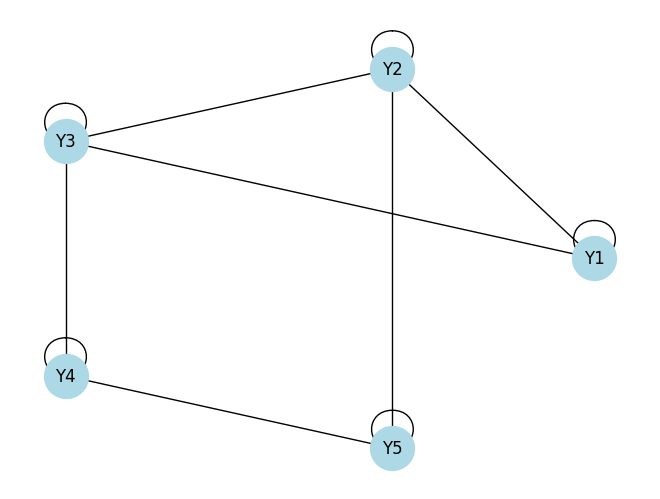

In [ ]:
print(adj_mats_mean>0.1)
print(adj_mats_mean1)
G = nx.from_numpy_array(adj_mats_mean1+np.eye(adj_mats_mean1.shape[0]))
G = nx.relabel_nodes(G,mapping1)
lay = nx.circular_layout(G)
nx.draw(G,pos = lay,with_labels = True,node_size = 1000,node_color = "lightblue")

In [ ]:
def compute_TP(adj_est):
  TP = 0
  total = 0
  for i in range(len(adj_est)):
    temp = np.diag(adj_est[i]>0.1,1).sum()+np.diag(adj_est[i]>0.1,-1).sum()
    TP += temp
    total += 2*adj_est[i].shape[0]-2
  return TP,TP/total, total
def compute_TN_mat(adj_est):
  TN = 0
  for i in range(2,adj_est.shape[0]):
    temp = np.diag(adj_est<0.1,i).sum()+np.diag(adj_est<0.1,-i).sum()
    TN += temp
  return TN
def compute_TN(adj_est):
  TN = 0
  total = 0
  for i in range(len(adj_est)):
    TN += compute_TN_mat(adj_est[i])
    total += adj_est[0].shape[0]**2-3*adj_est[0].shape[0]+2
  return TN,TN/total, total

def compute_abs_err(adj_est):
  TN = compute_TN(adj_est)
  TP = compute_TP(adj_est)
  acc = (TN[0]+TP[0])/(TN[2]+TP[2])
  prec = (TP[0])/(TP[0]+TN[2]-TN[0])
  rec = TP[1]
  f1 = 2*prec*rec/(prec+rec)
  return acc, prec, rec, f1


In [34]:
%reload_ext autoreload
%autoreload 2
from algo5 import SigComplex

params = {"win" : 75,
          "alpha_1d" : 1e-2,
          "alpha_2d" : 1e100,
          "depth" : 4
    }


adj_tensor = []
for step in tqdm(range(100)):
  adj_all1 = []

  scale = 100
  scale1 = 8

  N=5

  A = np.eye(2)+np.eye(2,k=1)/scale1-np.eye(2,k=-1)/scale1

  adj_true = block_diag(A,A,A,A,A)+np.eye(N*2,k=2)/scale+np.eye(N*2,k=-2)/scale

  T = 100

  test = generate_dynamic(adj_true,T,100,20)

  MultiTS = torch.tensor(test.reshape([5,2,T])).swapaxes(-1,-2)
  MultiTS -= MultiTS.mean(axis = 1)[:,None]
  MultiTS /= MultiTS.max(axis = 1)[0][:,None]

  for i in range(200):

    idx = np.sort(random.sample(range(MultiTS.shape[-2]),k=params["win"]))

    com = SigComplex(MultiTS[:,idx], win = params["win"], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=False, max_iter = 1000)

    _complex ,_ , adj_mat_1d= com.complex_creation(0,verbose=False)

    adj_all1.append(adj_mat_1d>0.1)

  adj_tensor.append(np.mean(np.array(adj_all1),axis = 0))



  0%|          | 0/100 [00:00<?, ?it/s]


AttributeError: 'Slope' object has no attribute 'score'

In [ ]:
print(compute_TP(adj_tensor))
print(compute_TN(adj_tensor))
print(compute_abs_err(adj_tensor))

In [ ]:
%reload_ext autoreload
%autoreload 2
from algo5 import SigComplex

params = {"win" : 75,
          "alpha_1d" : 1e-2,
          "alpha_2d" : 1e100,
          "depth" : 4
    }

N = 6

adj_tensor = []
for step in tqdm(range(100)):
  adj_all1 = []

  scale = 100
  scale1 = 8

  A = np.eye(2)+np.eye(2,k=1)/scale1-np.eye(2,k=-1)/scale1

  adj_true = block_diag(A,A,A,A,A,A)+np.eye(N*2,k=2)/scale+np.eye(N*2,k=-2)/scale

  T = 100

  test = generate_dynamic(adj_true,T,100,20)

  MultiTS = torch.tensor(test.reshape([N,2,T])).swapaxes(-1,-2)
  MultiTS -= MultiTS.mean(axis = 1)[:,None]
  MultiTS /= MultiTS.max(axis = 1)[0][:,None]

  for i in range(200):

    idx = np.sort(random.sample(range(MultiTS.shape[-2]),k=params["win"]))

    com = SigComplex(MultiTS[:,idx], win = params["win"], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=True, max_iter = 1000)

    _complex ,_ , adj_mat_1d= com.complex_creation(0,verbose=False)

    adj_all1.append(adj_mat_1d>0.1)

  adj_tensor.append(np.mean(np.array(adj_all1),axis = 0))

100%|██████████| 100/100 [05:33<00:00,  3.33s/it]


In [ ]:
print(compute_TP(adj_tensor))
print(compute_TN(adj_tensor))
print(compute_abs_err(adj_tensor))

(np.int64(751), np.float64(0.751), 1000)
(np.int64(1368), np.float64(0.684), 2000)
(np.float64(0.7063333333333334), np.float64(0.5430224150397687), np.float64(0.751), np.float64(0.6302979437683592))


In [ ]:
%reload_ext autoreload
%autoreload 2
from algo5 import SigComplex

params = {"win" : 75,
          "alpha_1d" : 1e-2,
          "alpha_2d" : 1e100,
          "depth" : 4
    }

N = 7

adj_tensor = []
for step in tqdm(range(100)):
  adj_all1 = []

  scale = 100
  scale1 = 8

  A = np.eye(2)+np.eye(2,k=1)/scale1-np.eye(2,k=-1)/scale1

  adj_true = block_diag(A,A,A,A,A,A,A)+np.eye(N*2,k=2)/scale+np.eye(N*2,k=-2)/scale

  T = 100

  test = generate_dynamic(adj_true,T,100,20)

  MultiTS = torch.tensor(test.reshape([N,2,T])).swapaxes(-1,-2)
  MultiTS -= MultiTS.mean(axis = 1)[:,None]
  MultiTS /= MultiTS.max(axis = 1)[0][:,None]

  for i in range(200):

    idx = np.sort(random.sample(range(MultiTS.shape[-2]),k=params["win"]))

    com = SigComplex(MultiTS[:,idx], win = params["win"], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=True, max_iter = 1000)

    _complex ,_ , adj_mat_1d= com.complex_creation(0,verbose=False)

    adj_all1.append(adj_mat_1d>0.1)

  adj_tensor.append(np.mean(np.array(adj_all1),axis = 0))

100%|██████████| 100/100 [06:40<00:00,  4.00s/it]


In [ ]:
print(compute_TP(adj_tensor))
print(compute_TN(adj_tensor))
print(compute_abs_err(adj_tensor))

(np.int64(804), np.float64(0.67), 1200)
(np.int64(2029), np.float64(0.6763333333333333), 3000)
(np.float64(0.6745238095238095), np.float64(0.4529577464788732), np.float64(0.67), np.float64(0.5405042016806723))


In [ ]:
%reload_ext autoreload
%autoreload 2
from algo5 import SigComplex

params = {"win" : 75,
          "alpha_1d" : 1e-2,
          "alpha_2d" : 1e100,
          "depth" : 4
    }

N = 8

adj_tensor = []
for step in tqdm(range(100)):
  adj_all1 = []

  scale = 100
  scale1 = 8


  A = np.eye(2)+np.eye(2,k=1)/scale1-np.eye(2,k=-1)/scale1

  adj_true = block_diag(A,A,A,A,A,A,A,A)+np.eye(N*2,k=2)/scale+np.eye(N*2,k=-2)/scale

  T = 100

  test = generate_dynamic(adj_true,T,100,20)

  MultiTS = torch.tensor(test.reshape([N,2,T])).swapaxes(-1,-2)
  MultiTS -= MultiTS.mean(axis = 1)[:,None]
  MultiTS /= MultiTS.max(axis = 1)[0][:,None]

  for i in range(200):

    idx = np.sort(random.sample(range(MultiTS.shape[-2]),k=params["win"]))

    com = SigComplex(MultiTS[:,idx], win = params["win"], depth = params["depth"], alpha_1d = params["alpha_1d"], alpha_2d = params["alpha_2d"],lasso=True, max_iter = 1000)

    _complex ,_ , adj_mat_1d= com.complex_creation(0,verbose=False)

    adj_all1.append(adj_mat_1d>0.1)

  adj_tensor.append(np.mean(np.array(adj_all1),axis = 0))

100%|██████████| 100/100 [07:43<00:00,  4.64s/it]


In [ ]:
print(compute_TP(adj_tensor))
print(compute_TN(adj_tensor))
print(compute_abs_err(adj_tensor))

(np.int64(947), np.float64(0.6764285714285714), 1400)
(np.int64(3036), np.float64(0.7228571428571429), 4200)
(np.float64(0.71125), np.float64(0.44860255802937), np.float64(0.6764285714285714), np.float64(0.5394474508686984))
